The script below was used to compute and visualize standard error in drug response data as seen in **Figure 5** of the paper 

###  *A multi-center study on factors influencing the reproducibility of in vitro drug-response studies*


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import itertools
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gr50
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
def compute_technical_variability(df, barcode_pairs, ax=None):
    """Computes the standard error for a given drug-dose condition
    across all technical replicates
    
    Parameter
    ---------
    df : pandas.DataFrame
       Input dataframe with GR values from a singe center or scientist across multiple
       technical/biological replicate plates
    barcode_pairs : list[list]
        A list of sets of technical replicates. 
        Example: [[biol_rep1_tech_rep1, biol_rep1_tech_rep2], 
                  [biol_rep2_tech_rep1, biol_rep2_tech_rep2]]
    ax : plot axis
    
    Returns
    -------
    df_technical_sem : pandas.DataFrame
        Standarard Error for each drug-dose condition across technical replicates
    """
    df_list = []
    for pair in barcode_pairs:
        df_tech_var = df[df.barcode.isin(pair)].groupby(
                        ['agent', 'concentration'])[
                            'GRvalue'].sem()
        df_list.append(df_tech_var)
        se_size_dep =  df[df.barcode.isin(pair)].groupby(
                        ['agent', 'concentration']).size().unique()
    df_technical_sem = pd.concat(df_list)
    if ax is not None:
        print('%s data points used on average to compute standard error' % se_size_dep)
        print('Kernel density estimate of distribution of standard error'
              '(%d SE data point)' % len(df_technical_sem.values.tolist()))
        sns.kdeplot(df_technical_sem.values.tolist(), shade=True, ax =ax, color='g')
    return df_technical_sem

In [3]:
def compute_biological_variability(df, barcode_pairs, ax=None):
    """Computes the standard error for a given drug-dose condition
    across all biological replicates
    
    Parameter
    ---------
    df : pandas.DataFrame
       Input dataframe with GR values from a singe center or scientist across multiple
       technical/biological replicate plates
    barcode_pairs : list[list]
        A list of sets of technical replicates. 
        Example: [[biol_rep1_tech_rep1, biol_rep1_tech_rep2], 
                  [biol_rep2_tech_rep1, biol_rep2_tech_rep2]]
    ax : plot axis
    
    Returns
    -------
    df_biological_sem : pandas.DataFrame
        Standarard Error for each drug-dose condition across biological replicates.
    """
    barcode_combinations = list(itertools.product(
        *barcode_pairs))

    df_list = []
    for comb in barcode_combinations:
        df_biol_var = df[df.barcode.isin(comb)].groupby(
            ['agent', 'concentration'])[
                'GRvalue'].sem()
        df_list.append(df_biol_var)

    df_biological_sem = pd.concat(df_list)    
    if ax is not None:
        sns.kdeplot(df_biological_sem.values.tolist(), shade=True, ax =ax, color='b')
    return df_biological_sem

In [4]:
def plot_grvalues_sem(df, barcode_pairs, figname=None):
    """Computes and plots the distribution of standard error (as kernel density estimate)
       across technical replicates (green) and biological replicates (blue)
    
    Parameter
    ---------
    df : pandas.DataFrame
       Input dataframe with GR values from a singe center or scientist across multiple
       technical/biological replicate plates
    barcode_pairs : list[list]
        A list of sets of technical replicates. 
        Example: [[biol_rep1_tech_rep1, biol_rep1_tech_rep2], 
                  [biol_rep2_tech_rep1, biol_rep2_tech_rep2]]
    figname : Optional[str]
        Name of output file.
    
    Returns
    -------
    dft : pandas.DataFrame
        Standarard Error for each drug-dose condition across technical replicates.        
    dfb : pandas.DataFrame
        Standarard Error for each drug-dose condition across biological replicates.
    """
    drugs = df.agent.unique()[::-1]
    
    fig=plt.figure(figsize=(5, 6))
    gs = GridSpec(2, 1,
              height_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    
    dft = compute_technical_variability(df, barcode_pairs, ax=ax1)
    #res = (dft)
    if len(barcode_pairs) > 1:
        dfb = compute_biological_variability(df, barcode_pairs, ax=ax1)
        #res = (*res, dfb)

    ax1.set_xlim((-0.01, 0.15))

    for i, drug in enumerate(drugs):
        ax2.hlines(y=i, xmin=dft.loc[drug].min(), xmax=dft.loc[drug].max(),
                  linewidth=4, color='g', alpha=0.5)
        ax2.vlines(x=dft.loc[drug].mean(), ymin=i-0.2, ymax=i+0.2)
        ax2.vlines(x=np.percentile(dft.loc[drug], 90), ymin=i-0.2, ymax=i+0.2,
                   color='r')
        ax2.set_yticks(range(len(drugs)))
        ax2.set_yticklabels(drugs)
        ax2.set_xlim((-0.01, 0.15))
    ax2.set_xlabel('Standard error in GR value')


    blue_patch = mpatches.Patch(color='b', label='biological replicates',
                                alpha=0.5)
    green_patch = mpatches.Patch(color='g', label='technical replicates',
                                 alpha=0.5)
    ax1.legend(handles=[green_patch, blue_patch])
    plt.subplots_adjust(left=0.2)
    if figname:
        plt.savefig(figname, dpi=300)
    return dft, dfb   


In [5]:
def compute_grmetrics_variability(dfv, dfg, barcode_pairs):
    """Computes and plots the distribution of standard error in GRmetrics
    
    Parameter
    ---------
    dfv : pandas.DataFrame
       Input dataframe with GR values from a singe center or scientist across multiple
       technical/biological replicate plates
    dfg : pandas.DataFrame
       Input dataframe with GR metrics from a singe center or scientist across multiple
       technical/biological replicate plates   
    barcode_pairs : list[list]
        A list of sets of technical replicates. 
        Example: [[biol_rep1_tech_rep1, biol_rep1_tech_rep2], 
                  [biol_rep2_tech_rep1, biol_rep2_tech_rep2]]
    
    Returns
    -------
    """

    dft = compute_technical_variability(dfv, barcode_pairs)
    technical_sem = np.array(dft.values.tolist())

    dfg['logGR50'] = dfg['GR50'].apply(np.log10)

    df_list = []
    for pair in barcode_pairs:
       df_tech_sem = dfg[dfg.barcode.isin(pair)].groupby(
           ['agent'])['GRmax', 'logGR50', 'GR_AOC', 'h_GR', 'GR50'].sem() 
       df_list.append(df_tech_sem)
    df_metrics_sem = pd.concat(df_list)   

    metrics = ['logGR50', 'GRmax', 'GR_AOC']

    fig, ax = plt.subplots()
    for i, metric in enumerate(metrics):
        ax.hlines(y=i, xmin=df_metrics_sem[metric].min(),
                  xmax=df_metrics_sem[metric].max(),
                  linewidth=4, color='g', alpha=0.5)
        ax.vlines(x=df_metrics_sem[metric].mean(), ymin=i-0.1, ymax=i+0.1)
        ax.vlines(x=np.percentile(df_metrics_sem[metric], 90), ymin=i-0.1, ymax=i+0.1,
                  color='r')
    ax.hlines(y=i+1, xmin=technical_sem.min(),
              xmax=technical_sem.max(),
              linewidth=4, color='g', alpha=0.5)
    ax.vlines(x=technical_sem.mean(), ymin=i+1-0.1, ymax=i+1+0.1)
    ax.vlines(x=np.percentile(technical_sem, 90), ymin=i+1-0.1, ymax=i+1+0.1,
              color='r')
    ax.set_yticks(range(len(metrics)+1))
    ax.set_yticklabels(metrics+['GRvalue'])
    ax.set_xlim((-0.01, 0.42))
    ax.set_xlabel('Standard error in GR values/metrics')
    plt.subplots_adjust(bottom=0.6)

### Figure 5A left panel

In [11]:
df_c1sb = pd.read_csv('../data/GRvalues_center1_scientistB.csv')

barcodes = df_c1sb.barcode.unique()
barcodes_batch1 = barcodes[:3]
barcodes_batch2 = barcodes[3:6]
barcodes_batch3 = barcodes[6:]

barcode_pairs = [barcodes_batch1, barcodes_batch2, barcodes_batch3]

[9] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(184 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


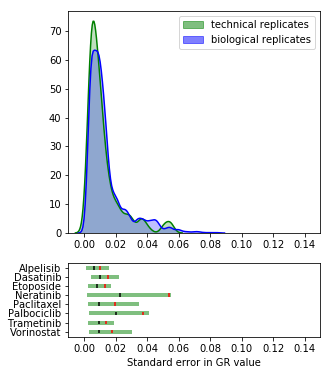

In [12]:
dft_c1sb, dfb_c1sb = plot_grvalues_sem(df_c1sb, barcode_pairs)


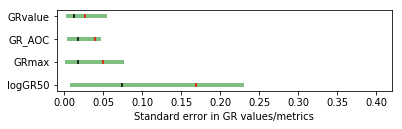

In [13]:
dfg = gr50.gr_metrics(df_c1sb, keys=['barcode','agent'])
dfg = dfg[~((dfg.agent == 'Alpelisib') & (dfg.barcode == '180622_BG_8'))].copy()
compute_grmetrics_variability(dfb, dfg, barcode_pairs)

## The distribution of standard error (kernel density estimate) for each center is computed and visauluzed below 

In [40]:
df_c4 = pd.read_csv('../data/GRvalues_center4.csv') # center 4
barcodes = df_c4.barcode.unique()
barcode_pairs = [barcodes[:3], barcodes[3:]]

[3 2] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(162 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


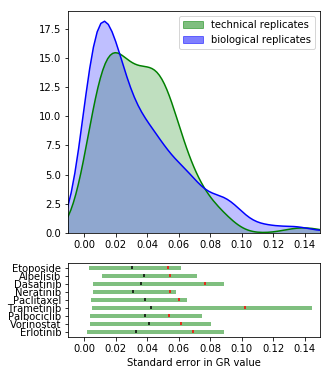

In [41]:
dft_c4, dfb_c4 = plot_grvalues_sem(df_c4, barcode_pairs)        


In [16]:
df_c1sc = pd.read_csv('../data/GRvalues_center1_scientistC.csv')
barcodes = df_c1sc.barcode.unique()
barcode_pairs = [barcodes[:4], barcodes[4:]]

[4 3] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(144 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


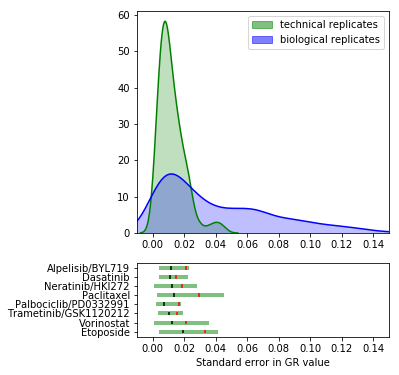

In [17]:
dft_c1sc, dfb_c1sc = plot_grvalues_sem(df_c1sc, barcode_pairs)   

In [18]:
df_c1sa17 = pd.read_csv('../data/GRvalues_center1_scientistA_2017.csv')
barcodes = df_c1sa17.barcode.unique()
barcode_pairs = [barcodes[:2], barcodes[2:4], barcodes[4:]]


[16 40 24 32] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(318 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


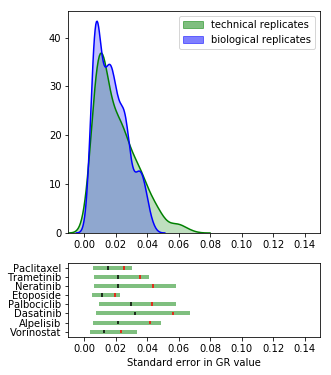

In [19]:
dft_2017, dfb_2017 = plot_grvalues_sem(df_c1sa17, barcode_pairs) 

In [20]:
df_c5 = pd.read_csv('../data/GRvalues_center5.csv') # center 5
barcodes = df_c5.barcode.unique()
barcode_pairs = [barcodes[:2], barcodes[2:]]

[ 4 10  6  8] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(212 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


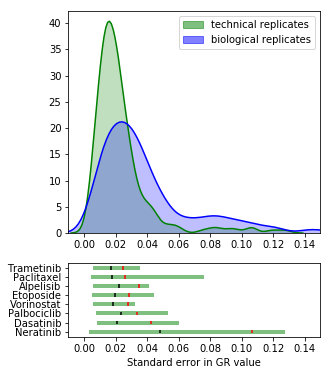

In [21]:
dft_c5, dfb_c5 = plot_grvalues_sem(df_c5, barcode_pairs) 

In [22]:
dt_c3 = pd.read_csv('../data/GRvalues_center3.csv')
barcodes = dt_c3.barcode.unique()
barcode_pairs = [barcodes[:3], barcodes[3:]]

[3] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(144 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


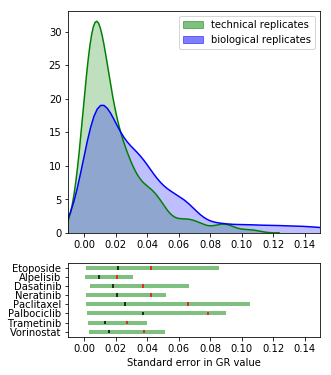

In [23]:
dft_c3, dfb_c3 = plot_grvalues_sem(dt_c3, barcode_pairs) 

In [24]:
df_c1sa2019 = pd.read_csv('../data/GRvalues_center1_scientistA_2019.csv')

barcodes = df_c1sa2019.barcode.unique()
barcodes_batch1 = barcodes[:3]
barcodes_batch2 = barcodes[3:6]
barcodes_batch3 = barcodes[6:]

barcode_pairs = [barcodes_batch1, barcodes_batch2, barcodes_batch3]

[9] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(183 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


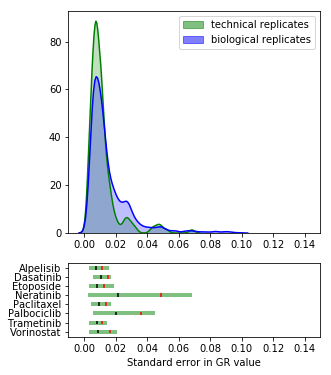

In [25]:
dft_2019, dfb_2019 = plot_grvalues_sem(df_c1sa2019, barcode_pairs) 

[4 2] data points used on average to compute standard error
Kernel density estimate of distribution of standard error(72 SE data point)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


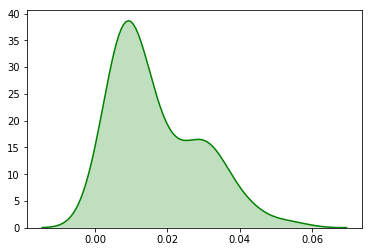

In [30]:
df_c2 = pd.read_csv('../data/GRvalues_center2.csv')# center 2
barcode_pairs = [df_c2.barcode.unique()]
fig, ax = plt.subplots()
dft_c2 = compute_technical_variability(df_c2, barcode_pairs, ax)

### Figure 5A center panel

In [48]:
# Technical and biological vairability within center 1
df_technical_center1 = pd.concat([dft_2017, dft_2019, dft_c1sb, dft_c1sc])
df_biological_center1 = pd.concat([dfb_2017, dfb_2019, dfb_c1sb, dfb_c1sc])
print(df_technical_center1.shape)

(829,)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,1,'Data from Center 1, Scientists A, B & C')

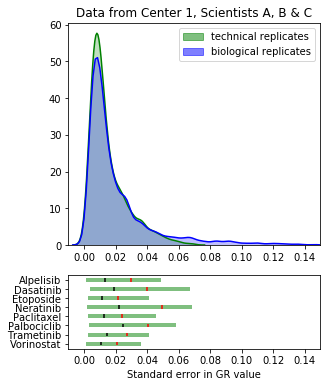

In [38]:
drugs = df_c1sb.agent.unique()[::-1]    
fig=plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1,
              height_ratios=[3, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.kdeplot(df_technical_center1.values.tolist(), shade=True, ax =ax1, color='g')
sns.kdeplot(df_biological_center1.values.tolist(), shade=True, ax =ax1, color='b')
ax1.set_xlim((-0.01, 0.15))

for i, drug in enumerate(drugs):
    ax2.hlines(y=i, xmin=df_technical_center1.loc[drug].min(), 
               xmax=df_technical_center1.loc[drug].max(),
              linewidth=4, color='g', alpha=0.5)
    ax2.vlines(x=df_technical_center1.loc[drug].mean(), ymin=i-0.2, ymax=i+0.2)
    ax2.vlines(x=np.percentile(df_technical_center1.loc[drug], 90), 
               ymin=i-0.2, ymax=i+0.2,
               color='r')
    ax2.set_yticks(range(len(drugs)))
    ax2.set_yticklabels(drugs)
    ax2.set_xlim((-0.01, 0.15))
ax2.set_xlabel('Standard error in GR value')
blue_patch = mpatches.Patch(color='b', label='biological replicates',
                            alpha=0.5)
green_patch = mpatches.Patch(color='g', label='technical replicates',
                             alpha=0.5)
ax1.legend(handles=[green_patch, blue_patch])
plt.subplots_adjust(left=0.2)
ax1.set_title('Data from Center 1, Scientists A, B & C')

### Figure 5A right panel

In [47]:
# Technical and biological vairability across all centers
dft_all = pd.concat([df_technical_center1, dft_c2, dft_c3, dft_c4, dft_c5])
dfb_all = pd.concat([df_biological_center1, dfb_c3, dfb_c4, dfb_c5])
print(len(dft_all))

1419


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,1,'Data from all centers')

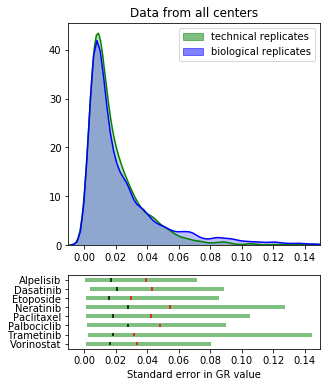

In [45]:
fig=plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1,
              height_ratios=[3, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.kdeplot(dft_all.values.tolist(), shade=True, ax =ax1, color='g')
sns.kdeplot(dfb_all.values.tolist(), shade=True, ax =ax1, color='b')
ax1.set_xlim((-0.01, 0.15))

for i, drug in enumerate(drugs):
    ax2.hlines(y=i, xmin=dft_all.loc[drug].min(), 
               xmax=dft_all.loc[drug].max(),
              linewidth=4, color='g', alpha=0.5)
    ax2.vlines(x=dft_all.loc[drug].mean(), ymin=i-0.2, ymax=i+0.2)
    ax2.vlines(x=np.percentile(dft_all.loc[drug], 90), 
               ymin=i-0.2, ymax=i+0.2,
               color='r')
    ax2.set_yticks(range(len(drugs)))
    ax2.set_yticklabels(drugs)
    ax2.set_xlim((-0.01, 0.15))
ax2.set_xlabel('Standard error in GR value')
blue_patch = mpatches.Patch(color='b', label='biological replicates',
                            alpha=0.5)
green_patch = mpatches.Patch(color='g', label='technical replicates',
                             alpha=0.5)
ax1.legend(handles=[green_patch, blue_patch])
plt.subplots_adjust(left=0.2)
ax1.set_title('Data from all centers')